In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.metrics import mean_squared_error
from scipy import stats

In [4]:
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.al import top_model as topmodel
from DomainPrediction.al.embeddings import one_hot_encode

In [ ]:
from DomainPrediction.esm.esm2 import ESM2
from DomainPrediction.al.confit import ESM2ConFit

In [5]:
sys.path.append('../../esm')
from DomainPrediction.esm.esm3 import ESM3LM
from DomainPrediction.esm.esmc import ESMCLM
from DomainPrediction.al.confit import ESMCConFit

#### Load Data

In [6]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/Envision'

In [7]:
file = os.path.join(data_path, 'dataset_tem1.csv')
df = pd.read_csv(file)

In [8]:
df.head()

,pos,variant,fitness_raw,fitness_norm,wt_aa,n_mut,seq,fold_id,split_id
0,58,F58N,1.537240,1.142208,F,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1,2
1,19,L19W,1.053720,1.094952,L,1,MSIQHFRVALIPFFAAFCWPVFAHPETLVKVKDAEDQLGARVGYIE...,0,2
2,15,A15Y,0.823567,1.072459,A,1,MSIQHFRVALIPFFYAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0,2
3,182,A182M,0.768011,1.067029,A,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,6,0
4,281,S281F,0.768011,1.067029,S,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,9,2


In [9]:
results_file = os.path.join(data_path, 'results_TEM1_zeroshot.csv')

In [10]:
if os.path.isfile(results_file):
    df_results = pd.read_csv(results_file)
else:
    df_results = df.copy()

In [11]:
df_results.head()

,pos,variant,fitness_raw,fitness_norm,wt_aa,n_mut,seq,fold_id,split_id,pred_ESM650M_masked_marginal,pred_ESM3_masked_marginal,pred_ESMC300M_masked_marginal,pred_ESMC600M_masked_marginal,pred_ESMC300M_confit
0,58,F58N,1.537240,1.142208,F,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1,2,-1.232786,-2.039062,-0.687500,0.750000,-2.8125
1,19,L19W,1.053720,1.094952,L,1,MSIQHFRVALIPFFAAFCWPVFAHPETLVKVKDAEDQLGARVGYIE...,0,2,-3.308943,-3.585938,-3.136719,-3.265625,-2.6250
2,15,A15Y,0.823567,1.072459,A,1,MSIQHFRVALIPFFYAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0,2,-2.954151,-3.800781,-2.390625,-2.734375,-0.7500
3,182,A182M,0.768011,1.067029,A,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,6,0,-1.501859,-0.421875,-1.750000,-1.632812,-1.0000
4,281,S281F,0.768011,1.067029,S,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,9,2,-2.640135,-3.921875,-1.984375,-2.078125,-1.0000


In [12]:
df_results.columns[df_results.columns.str.contains('pred')]

Index(['pred_ESM650M_masked_marginal', 'pred_ESM3_masked_marginal',
       'pred_ESMC300M_masked_marginal', 'pred_ESMC600M_masked_marginal',
       'pred_ESMC300M_confit'],
      dtype='object')

In [13]:
len(df_results.columns[df_results.columns.str.contains('pred')])

5

In [14]:
def get_split_mask(df, omit_zero=False):
    if omit_zero:
        train_mask = (df['split_id'] == 2)
    else:
        train_mask = (df['split_id'] == 2)

    val_mask = df['split_id'] == 1
    test_mask = df['split_id'] == 0

    return train_mask, val_mask, test_mask

#### OHE

In [ ]:
embeddings = one_hot_encode(df['seq'])

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)

X_train = embeddings[train_mask]
X_val = embeddings[val_mask]
X_test = embeddings[test_mask]

y_train = df.loc[train_mask, 'fitness_raw'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_raw'].to_numpy().astype(np.float32)
y_test = df.loc[test_mask, 'fitness_raw'].to_numpy().astype(np.float32)

# y_train = df.loc[train_mask, 'fitness_norm'].to_numpy().astype(np.float32)
# y_val = df.loc[val_mask, 'fitness_norm'].to_numpy().astype(np.float32)
# y_test = df.loc[test_mask, 'fitness_norm'].to_numpy().astype(np.float32)

In [ ]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_OHE_ridge'] = y_pred

mse = mean_squared_error(df_results['fitness_raw'], df_results['pred_OHE_ridge'])
corr = stats.spearmanr(df_results['fitness_raw'], df_results['pred_OHE_ridge'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
surrogate = topmodel.RFSurrogate()
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_OHE_RF'] = y_pred

mse = mean_squared_error(df_results['fitness_raw'], df_results['pred_OHE_RF'])
corr = stats.spearmanr(df_results['fitness_raw'], df_results['pred_OHE_RF'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
print(f'input layer shape: {X_train.shape[1]}')

In [ ]:
config={'layers': [5720, 512, 1], 
        'epoch': 100, 
        'batch_size': 16,
        'patience': 10,
        'early_stopping': True,
        'lr': 1e-3,
        'print_every_n_epoch': 10,
        'debug': True}
surrogate = topmodel.MLPSurrogate(config=config)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_OHE_MLP'] = y_pred

mse = mean_squared_error(df_results['fitness_raw'], df_results['pred_OHE_MLP'])
corr = stats.spearmanr(df_results['fitness_raw'], df_results['pred_OHE_MLP'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ESM2, ESM3 and ESMC Embeddings

In [ ]:
# esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
# esm3 = ESM3LM(device='gpu')
# esmc = ESMCLM(name='esmc_300m', device='gpu')
# esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
# embeddings = esm2.get_embeddings_flatten(df['seq'])
# embeddings = esm3.get_embeddings_flatten(df['seq'])
embeddings = esmc.get_embeddings_flatten(df['seq'])

In [ ]:
embeddings.shape

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)

X_train = embeddings[train_mask]
X_val = embeddings[val_mask]
X_test = embeddings[test_mask]

y_train = df.loc[train_mask, 'fitness_raw'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_raw'].to_numpy().astype(np.float32)
y_test = df.loc[test_mask, 'fitness_raw'].to_numpy().astype(np.float32)

# y_train = df.loc[train_mask, 'fitness_norm'].to_numpy().astype(np.float32)
# y_val = df.loc[val_mask, 'fitness_norm'].to_numpy().astype(np.float32)
# y_test = df.loc[test_mask, 'fitness_norm'].to_numpy().astype(np.float32)

In [ ]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_ESMC600M_concat_ridge'] = y_pred

mse = mean_squared_error(df_results['fitness_raw'], df_results['pred_ESMC600M_concat_ridge'])
corr = stats.spearmanr(df_results['fitness_raw'], df_results['pred_ESMC600M_concat_ridge'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
surrogate = topmodel.RFSurrogate()
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_ESMC600M_feat_mean_RF'] = y_pred

# mse = mean_squared_error(df_results['fitness_raw'], df_results['pred_ESMC600M_feat_mean_RF'])
# corr = stats.spearmanr(df_results['fitness_raw'], df_results['pred_ESMC600M_feat_mean_RF'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
print(f'input layer shape: {X_train.shape[1]}')

In [ ]:
config={'layers': [286, 64, 1], 
        'epoch': 100, 
        'batch_size': 16,
        'patience': 20,
        'early_stopping': True,
        'lr': 1e-3,
        'print_every_n_epoch': 10,
        'debug': True}
surrogate = topmodel.MLPSurrogate(config=config)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_ESMC600M_feat_mean_MLP'] = y_pred

# mse = mean_squared_error(df_results['fitness_raw'], df_results['pred_ESMC600M_feat_mean_MLP'])
# corr = stats.spearmanr(df_results['fitness_raw'], df_results['pred_ESMC600M_feat_mean_MLP'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ESM2, ESM3, ESMC - ZeroShot Margials

In [ ]:
# esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
# esm3 = ESM3LM(device='gpu')
# esmc = ESMCLM(name='esmc_300m', device='gpu')
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
wt_sequence = helper.read_fasta(os.path.join(data_path, 'TEM1_WT.fasta'), mode='str')[0]

In [ ]:
## masked marginals
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    # score, n_muts = esm2.get_masked_marginal(mt_sequence, wt_sequence)
    # score, n_muts = esm3.get_masked_marginal(mt_sequence, wt_sequence)
    score, n_muts = esmc.get_masked_marginal(mt_sequence, wt_sequence)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)

In [ ]:
y = df['fitness_raw'].to_numpy().astype(np.float32)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3,3), layout='constrained')

ax.plot(y, y_pred, '.', alpha=0.5)
mse = mean_squared_error(y, y_pred)
corr = stats.spearmanr(y, y_pred)
s_corr = round(corr.statistic, 2)
ax.set_title(f'Full Dataset \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')

train_mask, val_mask, test_mask = get_split_mask(df)

for i, (dset, _mask) in enumerate(zip(['train', 'val', 'test'], 
                                      [train_mask, val_mask, test_mask])):
    ax[i].plot(y[_mask], y_pred[_mask], '.', alpha=0.5)
    mse = mean_squared_error(y[_mask], y_pred[_mask])
    corr = stats.spearmanr(y[_mask], y_pred[_mask])
    s_corr = round(corr.statistic, 2)
    ax[i].set_title(f'{dset} \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

In [ ]:
# assert y_pred.shape[0] == df_results.shape[0]
# df_results['pred_ESMC600M_masked_marginal'] = y_pred

# mse = mean_squared_error(df_results['fitness_raw'], df_results['pred_ESMC600M_masked_marginal'])
# corr = stats.spearmanr(df_results['fitness_raw'], df_results['pred_ESMC600M_masked_marginal'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ConFit - Contrastive Fitness Learning

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)
df_train = df[train_mask]
df_val = df[val_mask]
df_test = df[test_mask]

In [ ]:
config={'epoch': 10, 
        'batch_size': 16,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 20,
        'early_stopping': False,
        'lr': 5e-4,
        'print_every_n_epoch': 1,
        'device': 'gpu'}
surrogate = ESMCConFit(name='esmc_300m', config=config)
surrogate.print_trainable_parameters(surrogate.model)

In [ ]:
wt_sequence = helper.read_fasta(os.path.join(data_path, 'TEM1_WT.fasta'), mode='str')[0]

In [ ]:
surrogate.sanity_check(df_train, wt_sequence)

In [ ]:
surrogate.trainmodel(df_train, wt_sequence, df_val)

In [ ]:
## masked marginals
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    score, n_muts = surrogate.get_masked_marginal(mt_sequence, wt_sequence)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)
y = df['fitness_raw'].to_numpy().astype(np.float32)

In [ ]:
y_train_pred, y_train = y_pred[train_mask], y[train_mask]
y_val_pred, y_val = y_pred[val_mask], y[val_mask]
y_test_pred, y_test = y_pred[test_mask], y[test_mask]

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.3)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# assert y_pred.shape[0] == df_results.shape[0]
# df_results['pred_ESMC300M_confit'] = y_pred

# mse = mean_squared_error(df_results['fitness_raw'], df_results['pred_ESMC300M_confit'])
# corr = stats.spearmanr(df_results['fitness_raw'], df_results['pred_ESMC300M_confit'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### Simulation Low-N setting

In [18]:
n_samples = 53

In [19]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)
print(f'n samples: train {train_mask.sum()} val {val_mask.sum()} test {test_mask.sum()}')

random_indices = df[train_mask].sample(n=n_samples, random_state=0).index
selected_mask = df.index.isin(random_indices)

train_mask_selected = selected_mask
train_mask_rest = train_mask & ~selected_mask
print(f'n samples: train selected {train_mask_selected.sum()} train rest {train_mask_rest.sum()}')

df_train = df[train_mask_selected]
df_train_rest = df[train_mask_rest]
df_val = df[val_mask]
df_test = df[test_mask]

n samples: train 3639 val 517 test 1042
n samples: train selected 53 train rest 3586


In [20]:
df_train.shape[0] + df_train_rest.shape[0] + df_val.shape[0] + df_test.shape[0] == df.shape[0]

True

In [ ]:
# Index([ 593, 1955, 2673, 1569, 4422, 3783, 4495, 2588, 1461,  410, 5104, 2561,
#        4194, 2647, 4675, 1503, 4722,  793, 3294, 5192, 4313, 4681,  306,  673,
#        3732, 1213, 4123, 4173,  247, 3459, 5033, 3498, 2718, 3406,  963,  158,
#        4658, 1970, 1328, 4207,  735, 3717,  119, 5038, 2925, 2602, 3560, 2376,
#         476, 4519,  768,  676, 2228],
#       dtype='int64')

In [21]:
random_indices

Index([ 593, 1955, 2673, 1569, 4422, 3783, 4495, 2588, 1461,  410, 5104, 2561,
       4194, 2647, 4675, 1503, 4722,  793, 3294, 5192, 4313, 4681,  306,  673,
       3732, 1213, 4123, 4173,  247, 3459, 5033, 3498, 2718, 3406,  963,  158,
       4658, 1970, 1328, 4207,  735, 3717,  119, 5038, 2925, 2602, 3560, 2376,
        476, 4519,  768,  676, 2228],
      dtype='int64')

In [22]:
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [23]:
embeddings = esmc.get_embeddings_flatten(df['seq'])

100%|██████████| 5198/5198 [02:56<00:00, 29.44it/s]


In [24]:
X_train = embeddings[train_mask_selected]
X_val = embeddings[val_mask]

y_train = df.loc[train_mask_selected, 'fitness_raw'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_raw'].to_numpy().astype(np.float32)

In [25]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

train: mse = 0.5309088826179504, spearman correlation = 0.982159776037644
val: mse = 9.14012622833252, spearman correlation = 0.7390129116828905


In [27]:
y_pred = surrogate.predict(embeddings)
y = df['fitness_raw'].to_numpy().astype(np.float32)

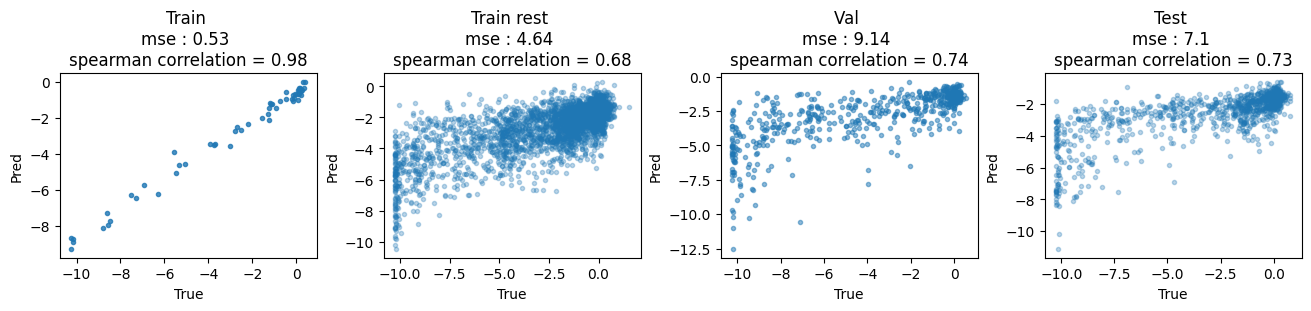

In [28]:
fig, ax = plt.subplots(1,4, figsize=(13,3), layout='constrained')

ax[0].plot(y[train_mask_selected], y_pred[train_mask_selected], '.', alpha=0.8)
ax[1].plot(y[train_mask_rest], y_pred[train_mask_rest], '.', alpha=0.3)
ax[2].plot(y[val_mask], y_pred[val_mask], '.', alpha=0.5)
ax[3].plot(y[test_mask], y_pred[test_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected], y_pred[train_mask_selected])
corr = stats.spearmanr(y[train_mask_selected], y_pred[train_mask_selected])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[train_mask_rest], y_pred[train_mask_rest])
corr = stats.spearmanr(y[train_mask_rest], y_pred[train_mask_rest])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Train rest \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[val_mask], y_pred[val_mask])
corr = stats.spearmanr(y[val_mask], y_pred[val_mask])
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[test_mask], y_pred[test_mask])
corr = stats.spearmanr(y[test_mask], y_pred[test_mask])
s_corr = round(corr.statistic, 2)
ax[3].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(4):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

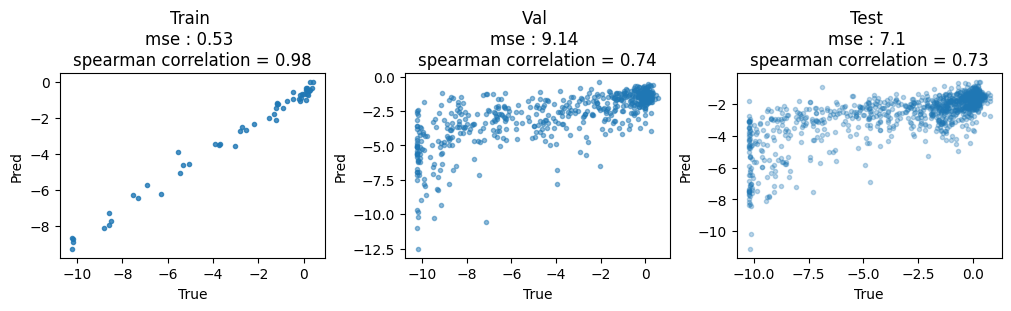

In [29]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')

ax[0].plot(y[train_mask_selected], y_pred[train_mask_selected], '.', alpha=0.8)
ax[1].plot(y[val_mask], y_pred[val_mask], '.', alpha=0.5)
ax[2].plot(y[test_mask], y_pred[test_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected], y_pred[train_mask_selected])
corr = stats.spearmanr(y[train_mask_selected], y_pred[train_mask_selected])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[val_mask], y_pred[val_mask])
corr = stats.spearmanr(y[val_mask], y_pred[val_mask])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[test_mask], y_pred[test_mask])
corr = stats.spearmanr(y[test_mask], y_pred[test_mask])
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [30]:
config={'epoch': 30, 
        'batch_size': 8,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 20,
        'early_stopping': False,
        'lr': 5e-4,
        'print_every_n_epoch': 1,
        'device': 'gpu'}
surrogate = ESMCConFit(name='esmc_600m', config=config)
surrogate.print_trainable_parameters(surrogate.model)

trainable params: 746496 || all params: 575700544 || trainable%: 0.13


In [31]:
wt_sequence = helper.read_fasta(os.path.join(data_path, 'TEM1_WT.fasta'), mode='str')[0]

In [32]:
surrogate.sanity_check(df_train, wt_sequence)

In [33]:
surrogate.trainmodel(df_train, wt_sequence, df_val)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 12GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-01-15 00:41:58.849915: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 00:41:59.933366: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 00:42:00.515135: E externa

Epoch: 0: train loss: 17.75996889386858 val loss: 51.051637253394496
Epoch: 1: train loss: 21.240145547049387 val loss: 51.001277175316446
Epoch: 2: train loss: 19.37377670833043 val loss: 51.216248835050145
Epoch: 3: train loss: 18.895242554800852 val loss: 50.9045571400569
Epoch: 4: train loss: 17.925250394003733 val loss: 51.438232377859265
Epoch: 5: train loss: 15.8398038319179 val loss: 51.283083211458646
Epoch: 6: train loss: 15.803572654724121 val loss: 51.37868100679838
Epoch: 7: train loss: 19.09700087138585 val loss: 51.36522786067082
Epoch: 8: train loss: 14.686251095363072 val loss: 51.62400056398832
Epoch: 9: train loss: 17.70344509397234 val loss: 51.391435520465556
Epoch: 10: train loss: 13.299886090414864 val loss: 51.47305016150841
Epoch: 11: train loss: 12.944813864571708 val loss: 51.44556601597713
Epoch: 12: train loss: 15.339736665998187 val loss: 51.53291551149808
Epoch: 13: train loss: 13.028101239885602 val loss: 51.554529615548944
Epoch: 14: train loss: 11.8164

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch: 30: train loss: 10.476623943873815 val loss: 48.73567978785588


In [35]:
## masked marginals
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    score, n_muts = surrogate.get_masked_marginal(mt_sequence, wt_sequence)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)
y = df['fitness_raw'].to_numpy().astype(np.float32)

5198it [03:24, 25.36it/s]


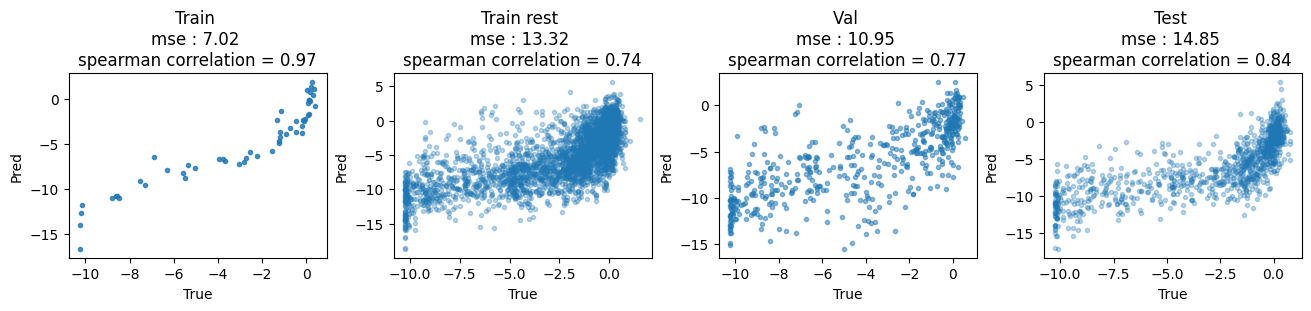

In [36]:
fig, ax = plt.subplots(1,4, figsize=(13,3), layout='constrained')

ax[0].plot(y[train_mask_selected], y_pred[train_mask_selected], '.', alpha=0.8)
ax[1].plot(y[train_mask_rest], y_pred[train_mask_rest], '.', alpha=0.3)
ax[2].plot(y[val_mask], y_pred[val_mask], '.', alpha=0.5)
ax[3].plot(y[test_mask], y_pred[test_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected], y_pred[train_mask_selected])
corr = stats.spearmanr(y[train_mask_selected], y_pred[train_mask_selected])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[train_mask_rest], y_pred[train_mask_rest])
corr = stats.spearmanr(y[train_mask_rest], y_pred[train_mask_rest])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Train rest \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[val_mask], y_pred[val_mask])
corr = stats.spearmanr(y[val_mask], y_pred[val_mask])
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[test_mask], y_pred[test_mask])
corr = stats.spearmanr(y[test_mask], y_pred[test_mask])
s_corr = round(corr.statistic, 2)
ax[3].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(4):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

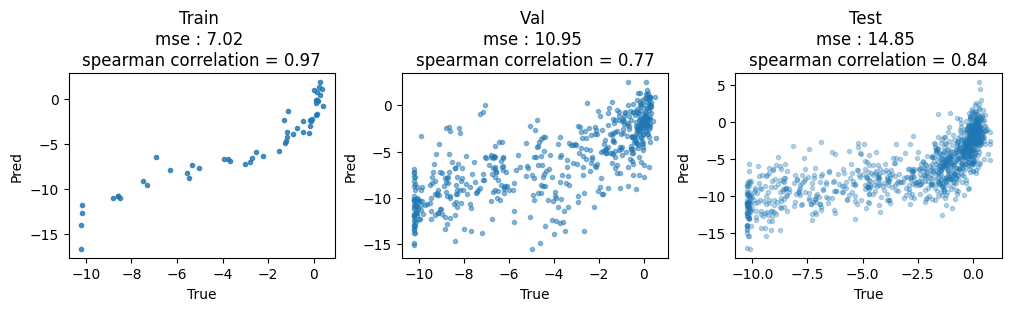

In [37]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')

ax[0].plot(y[train_mask_selected], y_pred[train_mask_selected], '.', alpha=0.8)
ax[1].plot(y[val_mask], y_pred[val_mask], '.', alpha=0.5)
ax[2].plot(y[test_mask], y_pred[test_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected], y_pred[train_mask_selected])
corr = stats.spearmanr(y[train_mask_selected], y_pred[train_mask_selected])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[val_mask], y_pred[val_mask])
corr = stats.spearmanr(y[val_mask], y_pred[val_mask])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[test_mask], y_pred[test_mask])
corr = stats.spearmanr(y[test_mask], y_pred[test_mask])
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()